# **Data Preparation & Preprocessing**

## Import module

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch, re, unicodedata, emoji
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from underthesea import word_tokenize

Set style for plot

In [31]:
sns.set_theme(style="whitegrid")

Check GPU

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## Load & filter data

### Processing file

In [33]:
from typing import Any

def process_dataframe(df:dict[str, pd.DataFrame], *process:Any):
    for key in df.keys():
        if process is None: continue
        for func in process:
            func(df, key)
            

In [34]:
def load_file(df, key):
    df[key] = pd.read_json(f'archive/UIT-VSFC-{key}.json')
    df[key] = df[key][(df[key]['topic'] == 'lecturer') & (df[key]['sentiment'] != 'neutral')].drop('topic', axis=1)
    df[key].reset_index(drop=True, inplace=True)
    print(f'{key} size: {df[key].shape}')
    display(df[key].head())

In [35]:
df = {
    'train': pd.DataFrame(),
    'dev': pd.DataFrame(),
    'test': pd.DataFrame()
}

try:
    process_dataframe(df, load_file)
except Exception as e:
    print(f"Errors: {e}")

train size: (7980, 2)


,sentence,sentiment
0,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive
1,chưa áp dụng công nghệ thông tin và các thiết ...,negative
2,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive
3,"giảng viên đảm bảo thời gian lên lớp , tích cự...",positive
4,thầy rất tận tình và đi dạy rất đúng giờ .,positive


dev size: (1119, 2)


,sentence,sentiment
0,giảng buồn ngủ .,negative
1,"giáo viên vui tính , tận tâm .",positive
2,"giảng viên nên giao bài tập nhiều hơn , chia n...",negative
3,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",negative
4,nên có giảng viên nước ngoài dạy để sinh viên ...,negative


test size: (2216, 2)


,sentence,sentiment
0,nói tiếng anh lưu loát .,positive
1,giáo viên rất vui tính .,positive
2,cô max có tâm .,positive
3,"giảng bài thu hút , dí dỏm .",positive
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",negative


### Label encoding

In [36]:
label_encoder = LabelEncoder()

df['train']['sentiment_encoded'] = label_encoder.fit_transform(df['train']['sentiment'])
df['dev']['sentiment_encoded'] = label_encoder.transform(df['dev']['sentiment'])
df['test']['sentiment_encoded'] = label_encoder.transform(df['test']['sentiment'])

for label, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoded}")

print(f"Train set:")
display(df['train'][['sentiment', 'sentiment_encoded']].head())
print(f"Dev set:")
display(df['dev'][['sentiment', 'sentiment_encoded']].head())
print(f"Test set:")
display(df['test'][['sentiment', 'sentiment_encoded']].head())

print("Phân phối nhãn sau khi encode:")
print("Train:")
print(df['train']['sentiment_encoded'].value_counts().sort_index())
print("Dev:")
print(df['dev']['sentiment_encoded'].value_counts().sort_index())
print("Test:")
print(df['test']['sentiment_encoded'].value_counts().sort_index())

negative: 0
positive: 1
Train set:


,sentiment,sentiment_encoded
0,positive,1
1,negative,0
2,positive,1
3,positive,1
4,positive,1


Dev set:


,sentiment,sentiment_encoded
0,negative,0
1,positive,1
2,negative,0
3,negative,0
4,negative,0


Test set:


,sentiment,sentiment_encoded
0,positive,1
1,positive,1
2,positive,1
3,positive,1
4,negative,0


Phân phối nhãn sau khi encode:
Train:
sentiment_encoded
0    2909
1    5071
Name: count, dtype: int64
Dev:
sentiment_encoded
0    405
1    714
Name: count, dtype: int64
Test:
sentiment_encoded
0     791
1    1425
Name: count, dtype: int64


### EDA

/tmp/ipykernel_1569/4029817500.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


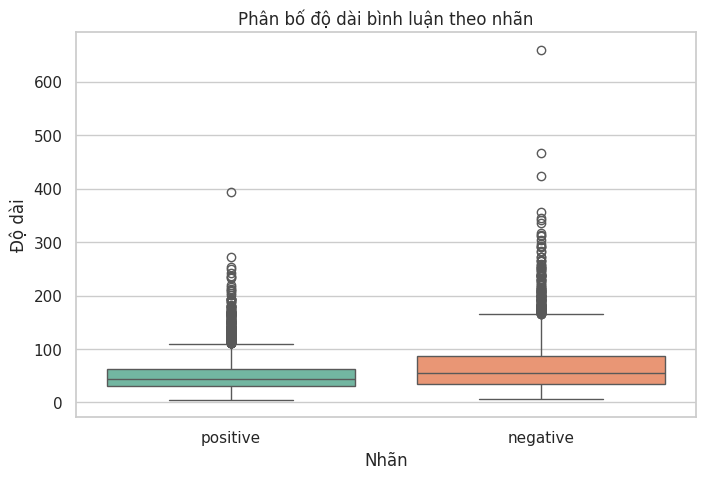

In [37]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x='sentiment',
    y=df['train']['sentence'].astype(str).apply(len),
    data=df['train'],
    palette='Set2'
)

plt.title('Phân bố độ dài bình luận theo nhãn')
plt.xlabel('Nhãn')
plt.ylabel('Độ dài')
plt.show()

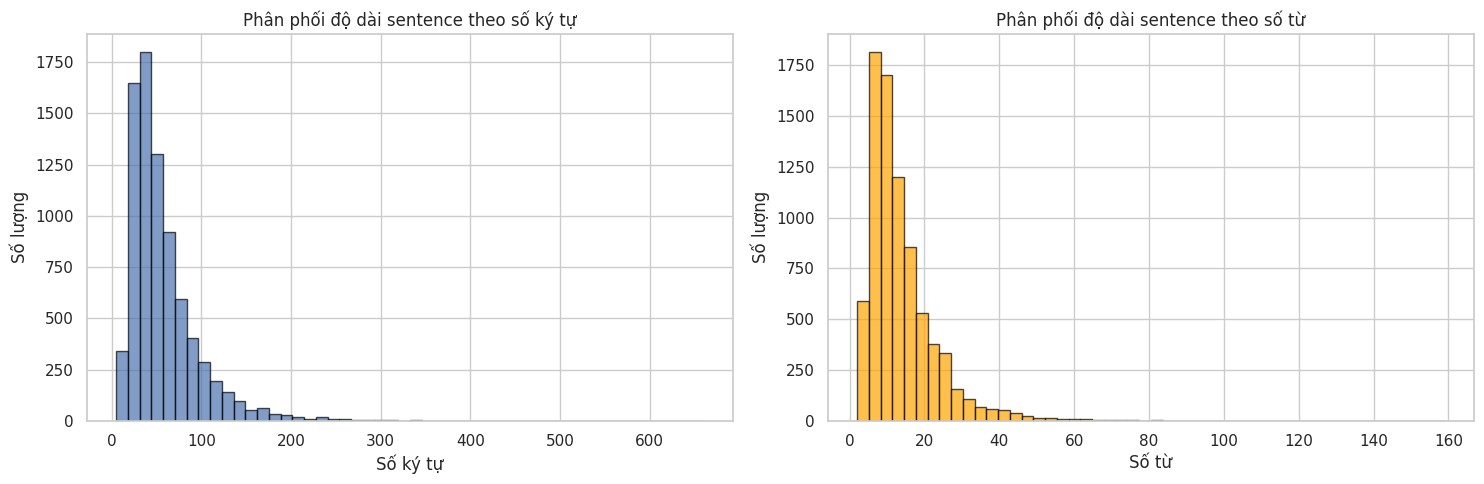

In [38]:
# Phân phối độ dài sentence theo số ký tự
df['train']['char_length'] = df['train']['sentence'].astype(str).apply(len)
df['train']['word_count'] = df['train']['sentence'].astype(str).apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram độ dài theo số ký tự
axes[0].hist(df['train']['char_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Phân phối độ dài sentence theo số ký tự')
axes[0].set_xlabel('Số ký tự')
axes[0].set_ylabel('Số lượng')

# Histogram độ dài theo số từ
axes[1].hist(df['train']['word_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Phân phối độ dài sentence theo số từ')
axes[1].set_xlabel('Số từ')
axes[1].set_ylabel('Số lượng')

plt.tight_layout()
plt.show()


In [39]:
# Thống kê mô tả độ dài sentence theo từng nhãn
stats_by_label = df['train'].groupby('sentiment')['char_length'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
stats_by_label.columns = ['Trung bình', 'Trung vị', 'Độ lệch chuẩn', 'Tối thiểu', 'Tối đa']

print("Thống kê độ dài sentence (số ký tự) theo nhãn:")
display(stats_by_label)

# Thống kê số từ
stats_words = df['train'].groupby('sentiment')['word_count'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
stats_words.columns = ['Trung bình', 'Trung vị', 'Độ lệch chuẩn', 'Tối thiểu', 'Tối đa']

print("\nThống kê số từ theo nhãn:")
display(stats_words)

Thống kê độ dài sentence (số ký tự) theo nhãn:


,Trung bình,Trung vị,Độ lệch chuẩn,Tối thiểu,Tối đa
sentiment,,,,,
negative,68.47,55.0,49.77,6,660
positive,50.55,43.0,30.18,5,394



Thống kê số từ theo nhãn:


,Trung bình,Trung vị,Độ lệch chuẩn,Tối thiểu,Tối đa
sentiment,,,,,
negative,16.37,13.0,11.77,2,159
positive,12.37,11.0,7.00,2,95


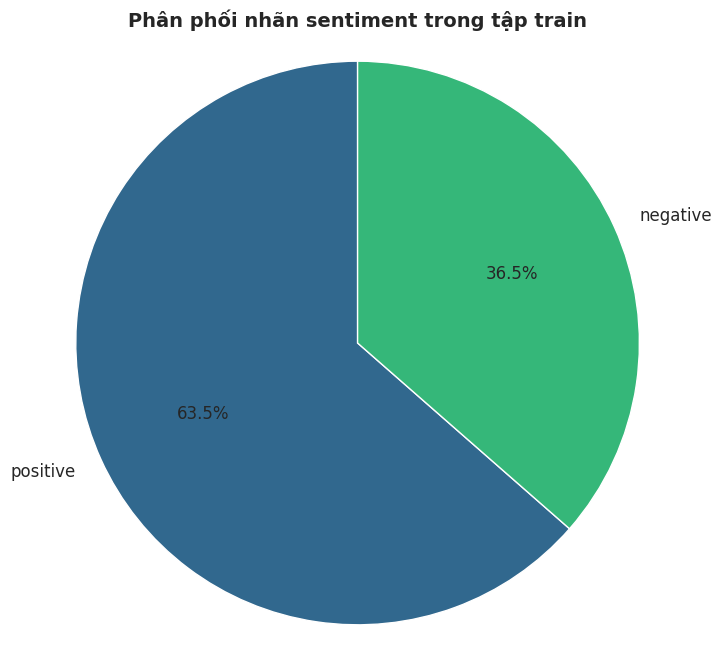

Số lượng từng nhãn:
  positive: 5071 (63.55%)
  negative: 2909 (36.45%)


In [40]:
# Pie chart phân phối nhãn
sentiment_counts = df['train']['sentiment'].value_counts()
colors = sns.color_palette('viridis', len(sentiment_counts))

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontsize': 12})
plt.title('Phân phối nhãn sentiment trong tập train', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

print("Số lượng từng nhãn:")
for sentiment, count in sentiment_counts.items():
    print(f"  {sentiment}: {count} ({count/len(df['train'])*100:.2f}%)")


Số lượng sentence có đặc điểm đặc biệt theo nhãn:


,Có URL,Có Emoji,Có ký tự lặp
positive,0,0,1
negative,0,0,1


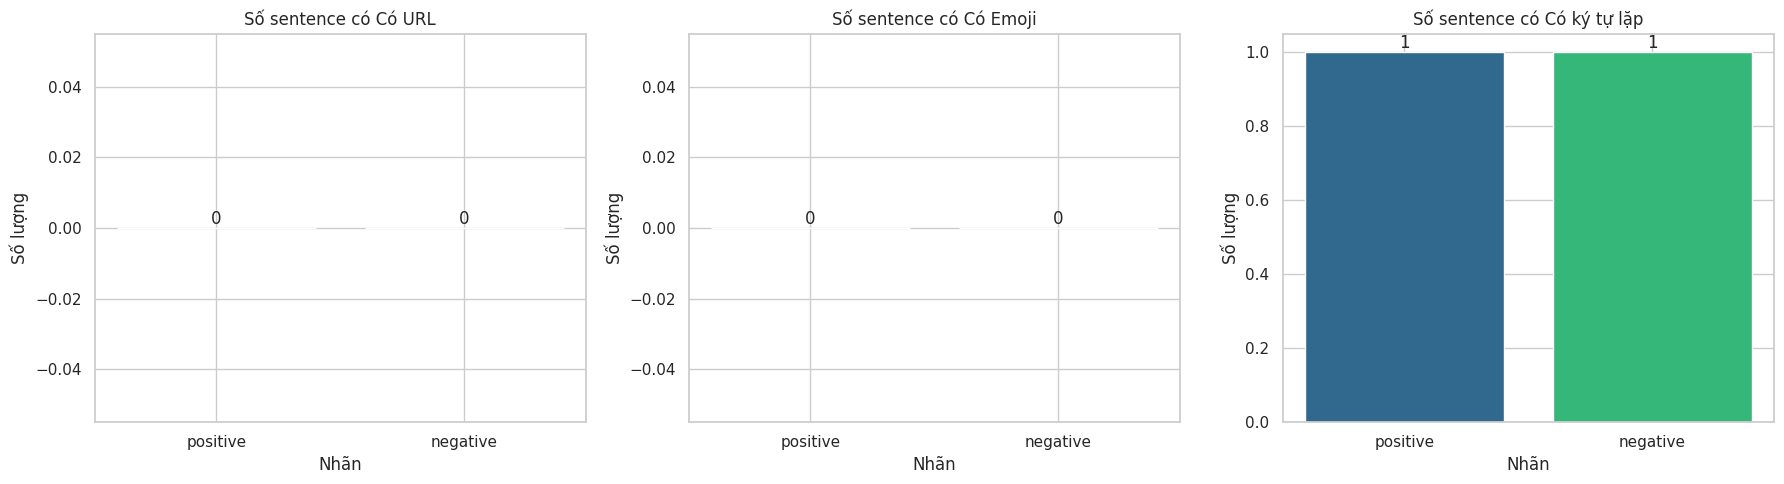

In [41]:
def has_url(text):
    if not isinstance(text, str):
        return False

    url_pattern = r'https?://\S+|www\.\S+'
    return bool(re.search(url_pattern, text))

def has_emoji(text):
    if not isinstance(text, str):
        return False

    try:
        return emoji.emoji_count(text) > 0
    except:
        # Fallback: kiểm tra bằng regex pattern cho emoji
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "\U00002702-\U000027B0"
            "\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
        return bool(emoji_pattern.search(text))

def has_repeated_chars(text):
    if not isinstance(text, str):
        return False

    return bool(re.search(r'(.)\1{2,}', text))

# Không thêm cột! Xử lý và tổng hợp trên-the-fly
feature_funcs = [("Có URL", has_url), ("Có Emoji", has_emoji), ("Có ký tự lặp", has_repeated_chars)]
special_features = {}
for label in df['train']['sentiment'].unique():
    mask = df['train']['sentiment'] == label
    sent_texts = df['train'].loc[mask, 'sentence']
    for feat_name, feat_func in feature_funcs:
        count = sent_texts.apply(feat_func).sum()
        special_features.setdefault(feat_name, {})[label] = count

special_features_df = pd.DataFrame(special_features).fillna(0).astype(int)
special_features_df = special_features_df.reindex(df['train']['sentiment'].unique())  # giữ đúng thứ tự label

print("Số lượng sentence có đặc điểm đặc biệt theo nhãn:")
display(special_features_df)

# Visualize bằng bar chart mà không cần cột trong dataframe
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (feat_name, _) in enumerate(feature_funcs):
    feature_counts = special_features_df[feat_name]
    axes[idx].bar(feature_counts.index, feature_counts.values, color=sns.color_palette('viridis', len(feature_counts)))
    axes[idx].set_title(f'Số sentence có {feat_name}')
    axes[idx].set_xlabel('Nhãn')
    axes[idx].set_ylabel('Số lượng')
    for i, v in enumerate(feature_counts.values):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Pre-processing text

Xử lý dấu câu

In [42]:
def remove_punctuation(text:str) -> str:
    """
    Loại bỏ tất cả dấu câu khỏi chuỗi văn bản.
    """
    import string
    return text.translate(str.maketrans('', '', string.punctuation))

Stop words

In [43]:
import requests

url_stop = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"
path_stop = "archive/vietnamese-stopwords.txt"
path_sent = "archive/vietnamese-semtimentwords.txt"
stopwords = set(requests.get(url_stop).text.strip().replace(' ', '_').split('\n') + open(path_stop, 'r', encoding='utf-8').read().split('\n'))
sentwords = set(open(path_sent, 'r', encoding='utf-8').read().split('\n'))
stopwords = stopwords - sentwords

def normalize_stopwords(text:str):
    tokens = text.split()
    clean_tokens = []

    for token in tokens:
        if token.startswith('wzjwz'):
            continue
        elif token in stopwords:
            continue

        clean_tokens.append(token)

    return ' '.join(clean_tokens)

Thống nhất bảng mã

In [44]:
def normalize_unicode(text:str):
    return unicodedata.normalize('NFC', text)

Xử lý ký tự lặp

In [45]:
def remove_duplicate_characters(text:str):
    return re.sub(r'(.)\1+', r'\1', text)

In [46]:
def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = text.lower().strip() # Lowercasing & Processing space
    text = normalize_unicode(text)
    text = remove_duplicate_characters(text)
    text = remove_punctuation(text)
    text = word_tokenize(text.lower(), format="text")
    text = normalize_stopwords(text)
    return text

Áp dụng các biện pháp xử lý

In [47]:
df['train']["sentence_process"] = df['train']["sentence"].apply(preprocess_text)
df['dev']["sentence_process"] = df['dev']["sentence"].apply(preprocess_text)
df['test']["sentence_process"] = df['test']["sentence"].apply(preprocess_text)

display(df['train'].head())
display(df['dev'].head())
display(df['test'].head())

,sentence,sentiment,sentiment_encoded,char_length,word_count,sentence_process
0,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive,1,46,11,nhiệt_tình gần_gũi
1,chưa áp dụng công nghệ thông tin và các thiết ...,negative,0,76,18,chưa áp_dụng công_nghệ_thông_tin thiết_bị
2,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive,1,59,15,hay nhiều
3,"giảng viên đảm bảo thời gian lên lớp , tích cự...",positive,1,120,28,tích_cực trả_lời câu thường_xuyên câu
4,thầy rất tận tình và đi dạy rất đúng giờ .,positive,1,42,11,rất tận_tình rất


,sentence,sentiment,sentiment_encoded,sentence_process
0,giảng buồn ngủ .,negative,0,buồn ngủ
1,"giáo viên vui tính , tận tâm .",positive,1,vui_tính tận_tâm
2,"giảng viên nên giao bài tập nhiều hơn , chia n...",negative,0,nên giao nhiều hơn chia giảng_kỹ trọng_tâm hiệ...
3,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",negative,0,chi_tiết hơn đi_sâu hơn code chạy thử chương_t...
4,nên có giảng viên nước ngoài dạy để sinh viên ...,negative,0,nên nước_ngoài giao_tiếp


,sentence,sentiment,sentiment_encoded,sentence_process
0,nói tiếng anh lưu loát .,positive,1,tiếng lưu_loát
1,giáo viên rất vui tính .,positive,1,rất vui_tính
2,cô max có tâm .,positive,1,max tâm
3,"giảng bài thu hút , dí dỏm .",positive,1,thu_hút dí dỏm
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",negative,0,không hướng_dẫn


### Sau tiền xử lý

Word Cloud

['positive', 'negative']
Label: positive


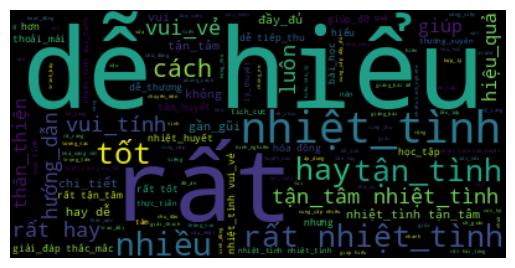

<Figure size 640x480 with 0 Axes>

Label: negative


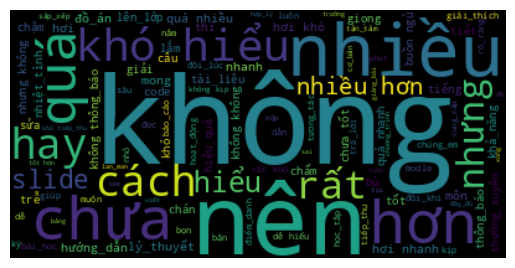

<Figure size 640x480 with 0 Axes>

In [48]:
def getWordCloud(words):
    text = ' '.join(words)
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    plt.figure()
    plt.show()

labels = df['train']['sentiment'].value_counts().index.tolist()
print(labels)

for label in labels:
    print(f"Label: {label}")
    word_list = []

    for senc in df['train'][df['train']['sentiment'] == label]['sentence_process']:
        if isinstance(senc, list):
            merged = ' '.join(senc)
        else:
            merged = senc
        word_list.append(merged)

    getWordCloud(word_list)

## Feature Extraction

TF-IDF vs N-grams

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
X_train = df['train']['sentence_process']
X_dev = df['dev']['sentence_process']
X_test = df['test']['sentence_process']

In [55]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
print(f"Kích thước tập huấn luyện (Training Set): {X_train_tfidf.shape}")
print(f"Kích thước tập huấn luyện (Validation Set): {X_dev_tfidf.shape}")
print(f"Kích thước tập kiểm thử (Test Set): {X_test_tfidf.shape}")
print(f"Tổng số đặc trưng (từ vựng và n-grams) được sử dụng: {X_train_tfidf.shape[1]}")


Kích thước tập huấn luyện (Training Set): (7980, 27636)
Kích thước tập huấn luyện (Validation Set): (1119, 27636)
Kích thước tập kiểm thử (Test Set): (2216, 27636)
Tổng số đặc trưng (từ vựng và n-grams) được sử dụng: 27636


# **Training model**

## Evaluation